In [1]:
import numpy as np
import scipy.signal as sig
import scipy.stats as stats
import matplotlib.pyplot as plt

import h5py as h5
import os, sys, glob

# Basic data structure

In [2]:
# where the data is located
# Download from https://gw-openscience.org/auxiliary/GW170814/
data_dir = '/data/datasets/gwosc' 

# name of a random file inside data_dir
file_name = '/L1_vII/L-L1_AUXR-1186741824-64.h5' 
# here 1186738240 is the gps starting time of the data; it is always an integer multiple of 64
# 64 is the duration in sec

# read the data
fid = h5.File(data_dir + file_name, 'r')

In [3]:
# top layer
print('Top level layers: (a sub system in LIGO)')
print([key for key in fid.keys()], '\n')

Top level layers: (a sub system in LIGO)
['ASC', 'HPI', 'IMC', 'ISI', 'LSC', 'OMC', 'PEM', 'PSL', 'SUS', 'TCS'] 



In [4]:
# and top level attributes
print('Top level attributes: ')
for attrs in fid.attrs:
    print(attrs, fid.attrs[attrs])
print('\n')

Top level attributes: 
duration 64
gps_start 1186741824
ifo L1




In [5]:
# secondary layer
grp_top = fid['ISI'] # take ISI for example

print('Secondary layers: (each corresponds to a LIGO channel)')
print([key for (key, cnt) in zip(grp_top.keys(), np.arange(5))], '\n\n') 

Secondary layers: (each corresponds to a LIGO channel)
['ISI-BS_CAL_CART_RX_OUT_DQ', 'ISI-BS_CAL_CART_RY_OUT_DQ', 'ISI-BS_CAL_CART_RZ_OUT_DQ', 'ISI-BS_CAL_CART_X_OUT_DQ', 'ISI-BS_CAL_CART_Y_OUT_DQ'] 




In [7]:
# inside each channel
# a valid channel
chan_val = grp_top['ISI-BS_CAL_CART_RX_OUT_DQ']
print('Attributes inside a valid channel: ')

# gps_start: gps starting time in sec
# duration: duration of data in sec
# fs: sampling rate in Hz (the one used in the released h5 files)
# fs0: original sampling rate in Hz (the one used in LIGO)
# valid: if the data stream is valid (i.e., not identically zero)
# note: description of the channel
# unit: the output is proportional to this physical unit
# cal: DC convertion factor from digital count to a physical unit (extra AC filters may be needed)
for attrs in chan_val.attrs:
    print(attrs, chan_val.attrs[attrs])

Attributes inside a valid channel: 
alias_50 8.224547335549522e-05
alias_90 0.00033516955282961907
cal 1.0E+00
duration 64
fs 256
fs0 1024.0
gps_start 1186741824
note vibration isolation table rotation (global IFO basis)
resi_50 2.582282222475128e-05
resi_90 7.098227591729522e-05
unit nrad
valid 1


In [9]:
print("Together it has a dataset: ['data'] ")
print(chan_val['data'][()])
print('\n')

Together it has a dataset: ['data'] 
[-5467.68175939 -5467.50112427 -5467.32085377 ...  -641.33464497
  -641.52481094  -641.71455897]




In [10]:
# an invalid channel
chan_inval = grp_top['ISI-ETMX_SUSPOINT_TMSX_EUL_L_DQ']
print('Attributes inside an invalid channel: ')
for attrs in chan_inval.attrs:
    print(attrs, chan_inval.attrs[attrs])
# valid = 0 means that
# the channel does not exist during the time released 
# or it is not in use and outputs identically zero

print('\n')
print('!!!')
print('To query data from a channel, please first check the valid flag!')
print('!!!')

Attributes inside an invalid channel: 
valid 0


!!!
To query data from a channel, please first check the valid flag!
!!!


## Try plotting data from a single channel

Text(0.5, 1.0, 'ISI-BS_CAL_CART_RX_OUT_DQ')

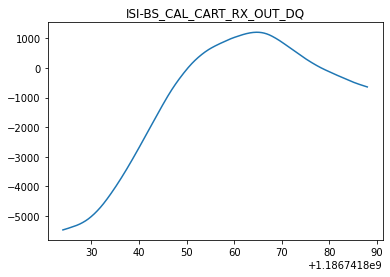

In [11]:
# -- Make a time vector
t0 = chan_val.attrs['gps_start']
dt = 1.0 / chan_val.attrs['fs']
dur = chan_val.attrs['duration']
time = np.arange(t0, t0+dur, dt)

# -- Plot the data
plt.plot(time, chan_val['data'][()])
plt.title('ISI-BS_CAL_CART_RX_OUT_DQ')

## Loop through all channels to check which are valid

In [13]:
# -- Count valid and invalid channels

filenamelist = ['/L1_vII/L-L1_AUXR-1186738240-64.h5', '/H1_vII/H-H1_AUXR-1186738240-64.h5']

totalvalid = 0
for fn in filenamelist:
    valid = 0
    invalid = 0
    fid = h5.File(data_dir + fn, 'r')
    
    # loop over groups of channels
    for k1 in fid.keys():
        grp = fid[k1]
        # loop over channels in the group
        for k2 in grp.keys():
            # if the channel is valid, get the data and print its properties
            if (grp[k2].attrs['valid']):
                valid += 1
            else:
                invalid += 1
                
    print("Checked file:", fn)
    print("Found {0} valid channels, {1} invalid channels \n".format(valid, invalid))
    totalvalid += valid
    
print("Found a total of {} valid channels".format(totalvalid))

Checked file: /L1_vII/L-L1_AUXR-1186738240-64.h5
Found 565 valid channels, 62 invalid channels 

Checked file: /H1_vII/H-H1_AUXR-1186738240-64.h5
Found 552 valid channels, 75 invalid channels 

Found a total of 1117 valid channels


## Plotting the Q transform of aux channels

In [39]:
from gwpy.timeseries import TimeSeries
from gwpy.time import from_gps
from gwpy.frequencyseries import FrequencySeries
from gwpy.detector import Channel

In [15]:
# Create the TimeSeries with data in auxiliary channel
t = TimeSeries(chan_val['data'])
# Properly setting the time attribute of the TimeSeries object
t.dt = 1.0 / (chan_val.attrs['fs'])
t.t0 = chan_val.attrs['gps_start']

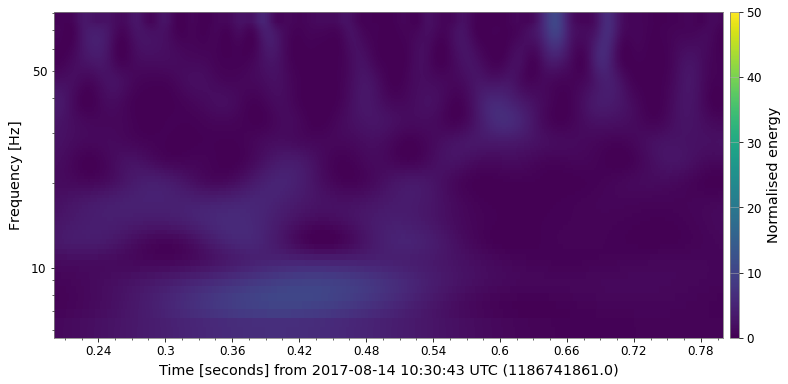

In [16]:
t0 = 1186741861.5  # GPS time of astrophisical event
dt = 0.3  # Desired width of q-transform plot, in seconds
hq = t.q_transform(outseg=(t0-dt, t0+dt))
fig = hq.plot()
ax = fig.gca()
mesh = ax.pcolormesh(hq)
mesh.set_clim(0, 50)
fig.colorbar(mesh, label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')

## Saving multiple Q transforms

In [ ]:
EVENT_TIME = 1186741861.5
START_TIME_EVENT = 1186741824  # Time to select to have the event within the file

In [ ]:
from torchvision import transforms
from PIL import Image
import os

In [ ]:
def q_trans_aux(gps_time=START_TIME_EVENT, H=False, subsystem='LSC', channel='LSC-DARM_OUT_DQ', time=EVENT_TIME, save_name='out1', save_dir='./non_strain_pictures/', save=True):
    
    ### Select the file
    file_dir = '/data/datasets/gwosc'
    file_name = '/L1_vII/L-L1_AUXR-' + str(gps_time) + '-64.h5'
    if H:
        file_name = '/H1_vII/H-H1_AUXR-' + str(gps_time) + '-64.h5'
    file_path = file_dir+file_name
    
    ### Open it with the h5 library, select subsystem and channel
    h5_file = h5.File(data_dir + file_name, 'r')
    subsys_data = h5_file[subsystem]
    chan_data = subsys_data[channel]
    
    # if the selected channel is not valid, exit the function
    if not chan_data.attrs['valid']:
        return
    
    ### Create the TimeSeries object
    t = TimeSeries(chan_data['data'])
    t.dt = 1.0 / (chan_data.attrs['fs'])  # the time step is assumed to be the inverse of the sampling frequency
    t.t0 = chan_data.attrs['gps_start']
    
    # Select the interval to consider for the Q transform, around the EVENT_TIME
    dt = 0.3
    hq = t.q_transform(outseg=(time-dt, time+dt))
    
    ### Create the figure, remove the frame, remove the axis, add the mesh that will represent the power values
    fig = plt.figure(frameon=False)
    ax = fig.add_axes([0, 0, 1, 1])
    mesh = ax.pcolormesh(hq)
    mesh.set_clim(0, 10)
    ax.grid(False)
    ax.set_yscale('log')
    ax.axis('off')
    # Close the figure so they don't get showed in the notebook
    plt.close(fig)
    
    # Define transforms: center crop the image then resize it to 256x256 pixel   
    y_size = fig.get_size_inches()[1]*fig.dpi
    crop = transforms.CenterCrop((y_size, y_size))
    resize = transforms.Resize((256, 256))
    transform = transforms.Compose([crop, resize])
    
    ### Save figure than apply transforms to the saved figure
    path = save_dir + str(time) + '-' + save_name + '.jpg'
    fig.savefig(path, bbox_inches='tight', pad_inches=0)
        
    image_file = Image.open(path)
    cropped_file = transform(image_file)
    cropped_file.save(path)
    
    if not save:
        to_tensor = transforms.ToTensor()
        tensor_img = to_tensor(cropped_file)
        os.remove(path)
        return tensor_img
    return None

In [ ]:
def q_trans_file(gps_time=START_TIME_EVENT, max_plots=0, H=False, subsystem='LSC', time=EVENT_TIME, save=True):
    
    ### Select the file
    file_dir = '/data/datasets/gwosc'
    file_name = '/L1_vII/L-L1_AUXR-' + str(gps_time) + '-64.h5'
    if H:
        file_name = '/H1_vII/H-H1_AUXR-' + str(gps_time) + '-64.h5'
    file_path = file_dir+file_name
    
    ### Open it with the h5 library, select the subsystem
    h5_file = h5.File(data_dir + file_name, 'r')
    subsys_data = h5_file[subsystem]
    
    ### Add every valid channel to the list
    channels = []
    for key in subsys_data.keys():
        # Most channels in this file seems to have a IN1 and a OUT version. I arbitrarily decided to keep only the OUT version
        if '_IN1_' in key:
            continue
        # Don't keep invalid channels
        if not subsys_data[key].attrs['valid']:
            continue
        # Some channels have just the same value at each time step, we let go of these for we can't perform a q-transform on them
        if subsys_data[key]['data'][()].min() == subsys_data[key]['data'][()].max():
            continue
        channels.append(key)
        # If max_plots is 0 we keep every good channel we find
        if len(channels) == max_plots:
            break
    
    i = 1
    j = 1
    strain_image = None
    aux_images = []
    ### We save the image for the strain channel (that contains DARM in the name) on the strain_image variable
    for channel in channels:
        if 'DARM' in channel:
            img = q_trans_aux(gps_time=gps_time, H=False, subsystem='LSC', channel=channel, time=time, save_name='strain'+str(i), 
                       save_dir='./non_strain_pictures/' if (not 'DARM' in channel) else './strain_pictures/', save=save)
            i += 1
            strain_image = img[0:3]
        else:
            img = q_trans_aux(gps_time=gps_time, H=False, subsystem='LSC', channel=channel, time=time, save_name='aux'+str(j), 
                       save_dir='./non_strain_pictures/' if (not 'DARM' in channel) else './strain_pictures/', save=save)
            j += 1
            # these have 4 channels, the fourth is just filled with 1., will be treated as transparency (alpha) if not removed
            aux_images.append(img[0:3])
    
    return strain_image, aux_images

## Create the dataset from the LSC subsystem

In [ ]:
import torch
data_directory = './dataset/'
data_directory_test = './test_dataset/'

### Function to save images in the concatenated format

def create_data(strain_image, aux_images, time, test=False):
    i = 1
    to_PIL = transforms.ToPILImage()
    for img in aux_images:
        data = torch.cat([strain_image, img], dim=2)
        final_image = to_PIL(data)
        if test:
            final_image.save(data_directory_test + str(time) + '_' + str(i) + '.jpg')
        else:
            final_image.save(data_directory + str(time) + '_' + str(i) + '.jpg')
        i += 1

In [ ]:
all_times = np.sort(np.array([int(i[10:20]) for i in os.listdir('/data/datasets/gwosc/L1_vII')]))

def q_trans_time(start_time):
    time_search = np.sort(np.array([i for i in all_times - start_time if i < 0]))
    file_time = all_times[len(time_search)-1]
    L_files = q_trans_file(gps_time=file_time, max_plots=0, H=False, subsystem='LSC', time=start_time, save=False)
    
    return L_files

In [ ]:
# Since there are 10 aux channels in the same file where there is the strain signal, by inserting 50 time values to process,
# we will create 500 images, the time steps will be consecutive

time_values = []

for i in range(50):
    time_values.append(1186741861.5 - 0.3 * 25 + 0.3 * i)

In [ ]:
import time

start_time = time.time()

for a_time in time_values:
    Ls = q_trans_time(a_time)
    if not (Ls[0] is None):
        create_data(Ls[0], Ls[1], a_time)
        
elapsed_time = time.time() - start_time
print('The process took ' + str(elapsed_time) + ' seconds')

In [ ]:
time_values_test = []

for i in range(25):
    time_values_test.append(1186741861.5 - 0.3 * 50 + 0.3 * i)

In [ ]:
for a_time in time_values_test:
    Ls = q_trans_time(a_time)
    if not (Ls[0] is None):
        create_data(Ls[0], Ls[1], a_time, test=True)